# IMPROVE RESULTS

We study whether the normalization log affects the performance as indicated in the Bioarxiv experiment

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

# import deconvolution methods
import cellanneal
from scipy.optimize import nnls
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler


# statistical tests
import scipy.stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# stats & plot specific from .py files
from src.plot import Plot
from stats import statsTest
from src.helper import flatten, gene_intersection
import src.project_configs as project_configs
from src.deconv import Deconvolution
from sklearn import preprocessing

from tqdm import tqdm

train_flag = False

In [23]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/marker_gene_expression.by_compartments.csv", index_col=0).T
atap_bulk = pd.read_csv('../data/atap.pseudobulk.normal_log.csv',index_col=0).T
atap_true = pd.read_csv('../data/atap.scg_proportions.csv',index_col=0).T
cleveland_bulk = pd.read_csv('../data/cleveland.pseudobulk.normal_log.csv',index_col=0).T
cleveland_true = pd.read_csv('../data/cleveland.scg_proportions.csv',index_col=0).T
lmu_bulk = pd.read_csv('../data/lmu.pseudobulk.normal_log.csv',index_col=0).T
lmu_true = pd.read_csv('../data/lmu.scg_proportions.csv',index_col=0).T

In [14]:
signature

,KDR,IGKV1D-8,MS4A1,LGI4,KCNE4,ARC,LYPD8,TRGC2,MCM8,SCG3,...,GUCA2A,CCL5,SELE,LY86,MAP1B,PIK3R5,CTLA4,SOX17,CD68,CXCL11
B Cell,0.000570,0.001335,0.681195,0.000206,0.000245,0.001846,0.000300,0.000745,0.023859,0.000184,...,0.002904,0.026275,0.000677,0.153331,0.009277,0.013040,0.003462,0.000134,0.007961,0.000770
Epithelium,0.001089,0.000000,0.001444,0.004018,0.001603,0.040618,0.073668,0.000392,0.015079,0.027238,...,0.183301,0.007441,0.000779,0.000691,0.024351,0.016007,0.001163,0.000372,0.028243,0.003789
Myeloid,0.000734,0.000000,0.003898,0.000724,0.000060,0.002197,0.000858,0.002066,0.008826,0.000358,...,0.003959,0.016699,0.000696,0.124297,0.000771,0.028485,0.004524,0.000211,0.315962,0.023583
Stroma,0.124541,0.000075,0.001195,0.148604,0.090809,0.018739,0.001119,0.000467,0.013213,0.002488,...,0.003467,0.006411,0.087481,0.000744,0.226988,0.000449,0.000871,0.057668,0.012182,0.010364
T Cell,0.000624,0.000000,0.006372,0.000845,0.000388,0.009732,0.000780,0.155789,0.016764,0.000034,...,0.004669,0.843957,0.000872,0.002864,0.001224,0.035005,0.186955,0.000441,0.006138,0.000091
Unknown,0.002537,0.001989,0.070019,0.005531,0.001103,0.002333,0.075662,0.026217,0.003210,0.000151,...,0.170068,0.209739,0.001188,0.030865,0.007225,0.005545,0.016716,0.001940,0.006983,0.001263


In [24]:
index = signature.index
col = signature.columns
df = preprocessing.normalize(signature)
data = np.log1p(df)
signature = pd.DataFrame(data, columns=col, index = index)
signature

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Unknown
KDR,0.004567,0.008704,0.005878,0.693004,0.004999,0.020164
IGKV1D-8,0.442725,0.000000,0.000000,0.030886,0.000000,0.604293
MS4A1,0.690492,0.002106,0.005676,0.001744,0.009261,0.097347
LGI4,0.001383,0.026650,0.004854,0.692604,0.005662,0.036503
KCNE4,0.002694,0.017493,0.000664,0.693026,0.004266,0.012072
...,...,...,...,...,...,...
PIK3R5,0.232002,0.278027,0.451324,0.008955,0.531185,0.105291
CTLA4,0.018268,0.006174,0.023806,0.004626,0.690914,0.085272
SOX17,0.002315,0.006420,0.003650,0.692835,0.007619,0.033072
CD68,0.024749,0.085169,0.690422,0.037629,0.019135,0.021741


In [16]:
atap_true_general =pd.DataFrame()          
atap_true_general['Myeloid'] = atap_true['CD209+ moDC'] + atap_true['CD83+ CLEC9A+ DC'] + atap_true['CD83- CLEC9A+ DC']+atap_true['CLEC10A+ DC']+atap_true['IL7R+ Activated DC']+atap_true['Mast Cell']+atap_true['Memory B cell']+atap_true['Monocyte Inflammatory']+atap_true['Proliferating myeloid']+atap_true['Resident Macrophage']
atap_true_general['T Cell'] = atap_true['CD4 SELL naive'] + atap_true['CD4 TRM'] + atap_true['CD4 Tfh']+atap_true['CD4 Th17']+atap_true['CD4 Tph']+atap_true['CD4 Treg']+atap_true['CD8 Effector']+atap_true['CD8 IEL']+atap_true['CD8 SELL Naive']+atap_true['ILC3']+atap_true['MAIT']+atap_true['NK']+atap_true['Proliferating T cells']+atap_true['gd T cell 1']+atap_true['gd T cell 2']
atap_true_general['B Cell'] = atap_true['GC-like B cell'] + atap_true['Memory B cell'] + atap_true['Naive B cell']+atap_true['Plasma Cell']+atap_true['Plasmablast']
atap_true_general['Stroma'] = atap_true['Arterial Pericyte'] + atap_true['Blood Endothelial Cell'] + atap_true['Fibroblast']+atap_true['Glial Cell']+atap_true['Inflammatory Fibroblast']+atap_true['Myofibroblast']+atap_true['Pericyte']+atap_true['Post-capillary venules']+atap_true['Proliferating Stromal Cell']+atap_true['Smooth Muscle Cell']
atap_true_general['Epithelium'] = atap_true['Enterocyte'] + atap_true['Enteroendocrine Cell'] + atap_true['Epithelial M Cell']+atap_true['Epithelial Progenitor Cell']+atap_true['Epithelial Stem Cell']+atap_true['Goblet Cell']+atap_true['Tuft Cell']

In [17]:
cleveland_true_general =pd.DataFrame()          
cleveland_true_general['Myeloid'] = cleveland_true['CD209+ moDC'] + cleveland_true['CD83+ CLEC9A+ DC'] + cleveland_true['CD83- CLEC9A+ DC']+cleveland_true['CLEC10A+ DC']+cleveland_true['IL7R+ Activated DC']+cleveland_true['Mast Cell']+cleveland_true['Memory B cell']+cleveland_true['Monocyte Inflammatory']+cleveland_true['Proliferating myeloid']+cleveland_true['Resident Macrophage']
cleveland_true_general['T Cell'] = cleveland_true['CD4 SELL naive'] + cleveland_true['CD4 TRM'] + cleveland_true['CD4 Tfh']+cleveland_true['CD4 Th17']+cleveland_true['CD4 Tph']+cleveland_true['CD4 Treg']+cleveland_true['CD8 Effector']+cleveland_true['CD8 IEL']+cleveland_true['CD8 SELL Naive']+cleveland_true['ILC3']+cleveland_true['MAIT']+cleveland_true['NK']+cleveland_true['Proliferating T cells']+cleveland_true['gd T cell 1']+cleveland_true['gd T cell 2']
cleveland_true_general['B Cell'] = cleveland_true['GC-like B cell'] + cleveland_true['Memory B cell'] + cleveland_true['Naive B cell']+cleveland_true['Plasma Cell']+cleveland_true['Plasmablast']
cleveland_true_general['Stroma'] = cleveland_true['Arterial Pericyte'] + cleveland_true['Blood Endothelial Cell'] + cleveland_true['Fibroblast']+cleveland_true['Glial Cell']+cleveland_true['Inflammatory Fibroblast']+cleveland_true['Myofibroblast']+cleveland_true['Pericyte']+cleveland_true['Post-capillary venules']+cleveland_true['Proliferating Stromal Cell']+cleveland_true['Smooth Muscle Cell']
cleveland_true_general['Epithelium'] = cleveland_true['Enterocyte'] + cleveland_true['Enteroendocrine Cell'] + cleveland_true['Epithelial M Cell']+cleveland_true['Epithelial Progenitor Cell']+cleveland_true['Epithelial Stem Cell']+cleveland_true['Goblet Cell']+cleveland_true['Tuft Cell']

In [18]:
lmu_true_general =pd.DataFrame()          
lmu_true_general['Myeloid'] = lmu_true['CD209+ moDC'] + lmu_true['CD83+ CLEC9A+ DC'] + lmu_true['CD83- CLEC9A+ DC']+lmu_true['CLEC10A+ DC']+lmu_true['IL7R+ Activated DC']+lmu_true['Mast Cell']+lmu_true['Memory B cell']+lmu_true['Monocyte Inflammatory']+lmu_true['Proliferating myeloid']+lmu_true['Resident Macrophage']
lmu_true_general['T Cell'] = lmu_true['CD4 SELL naive'] + lmu_true['CD4 TRM'] + lmu_true['CD4 Tfh']+lmu_true['CD4 Th17']+lmu_true['CD4 Tph']+lmu_true['CD4 Treg']+lmu_true['CD8 Effector']+lmu_true['CD8 IEL']+lmu_true['CD8 SELL Naive']+lmu_true['ILC3']+lmu_true['MAIT']+lmu_true['NK']+lmu_true['Proliferating T cells']+lmu_true['gd T cell 1']+lmu_true['gd T cell 2']
lmu_true_general['B Cell'] = lmu_true['GC-like B cell'] + lmu_true['Memory B cell'] + lmu_true['Naive B cell']+lmu_true['Plasma Cell']+lmu_true['Plasmablast']
lmu_true_general['Stroma'] = lmu_true['Arterial Pericyte'] + lmu_true['Blood Endothelial Cell'] + lmu_true['Fibroblast']+lmu_true['Glial Cell']+lmu_true['Inflammatory Fibroblast']+lmu_true['Myofibroblast']+lmu_true['Pericyte']+lmu_true['Post-capillary venules']+lmu_true['Proliferating Stromal Cell']+lmu_true['Smooth Muscle Cell']
lmu_true_general['Epithelium'] = lmu_true['Enterocyte'] + lmu_true['Enteroendocrine Cell'] + lmu_true['Epithelial M Cell']+lmu_true['Epithelial Progenitor Cell']+lmu_true['Epithelial Stem Cell']+lmu_true['Goblet Cell']+lmu_true['Tuft Cell']

In [19]:
deconvolution_object = Deconvolution()
plot_object = Plot()

In [31]:
if train_flag:
    models = deconvolution_object.deconvolution(signature, atap_bulk)
    models.to_csv("../data/results6/cellanneal_atap.csv")
    models = deconvolution_object.deconvolution(signature, cleveland_bulk)
    models.to_csv("../data/results6/cellanneal_cleveland.csv")
    models = deconvolution_object.deconvolution(signature, lmu_bulk)
    models.to_csv("../data/results6/cellanneal_lmu.csv")

else:
    cellanneal_atap = pd.read_csv("../data/results6/cellanneal_atap.csv",index_col=0)
    cellanneal_cleveland = pd.read_csv("../data/results6/cellanneal_cleveland.csv",index_col=0)
    cellanneal_lmu =  pd.read_csv("../data/results6/cellanneal_lmu.csv",index_col=0)

In [29]:
cells_p = {'B Cell': '#558ce0',
            'T Cell': '#28a35c',
            'Myeloid': '#58d3bb',
            'Stroma': '#eaabcc',
            'Epithelium': '#F6783E',
}

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.597\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.302\np = 0.008'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = -0.3\np = 0.008'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.329\np = 0.004'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.715\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

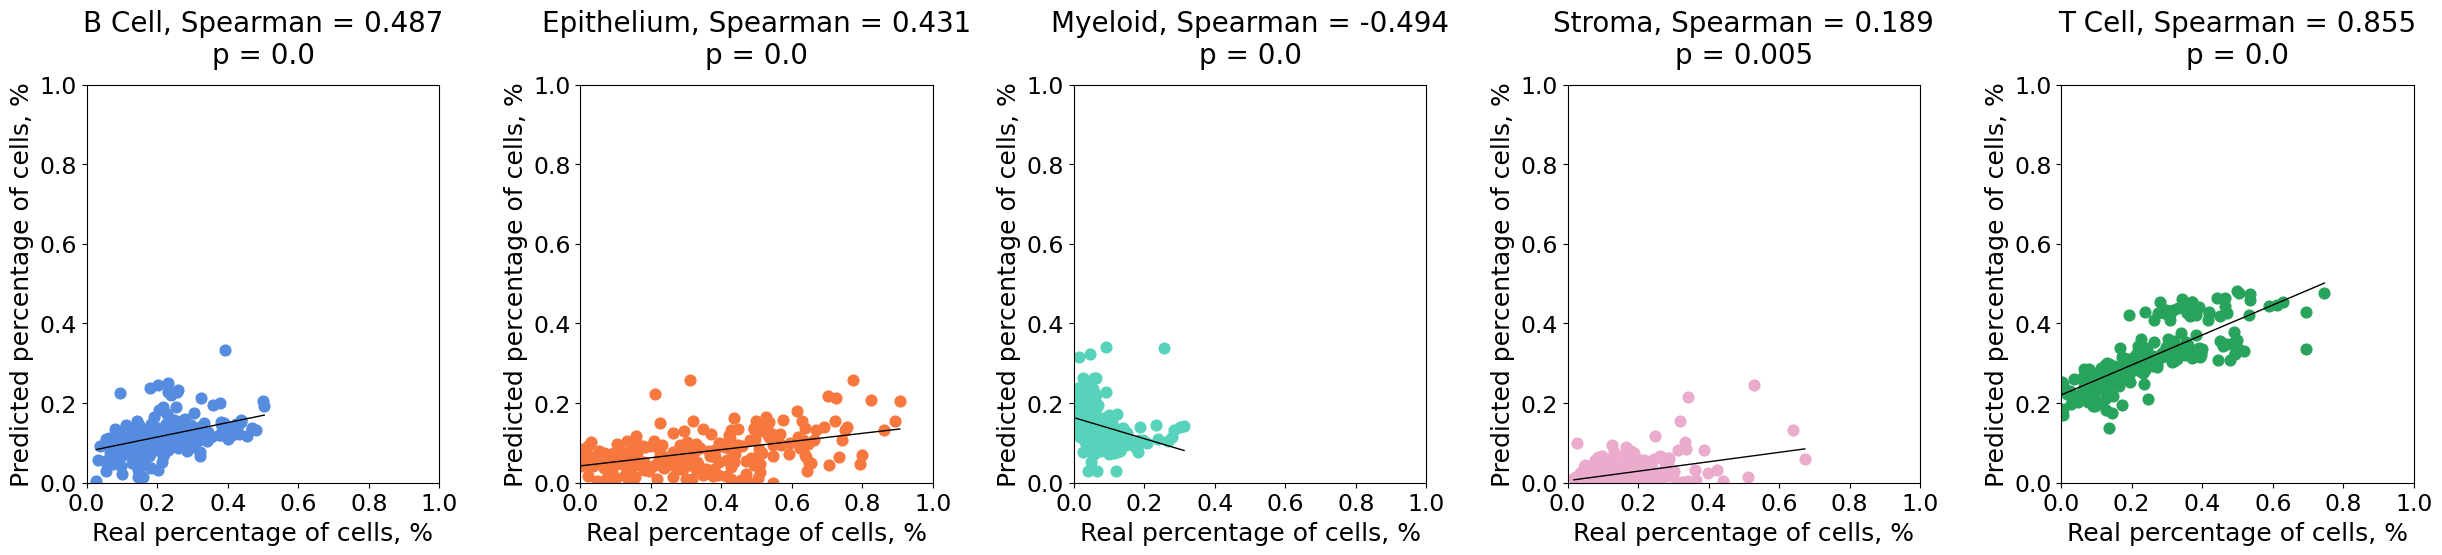

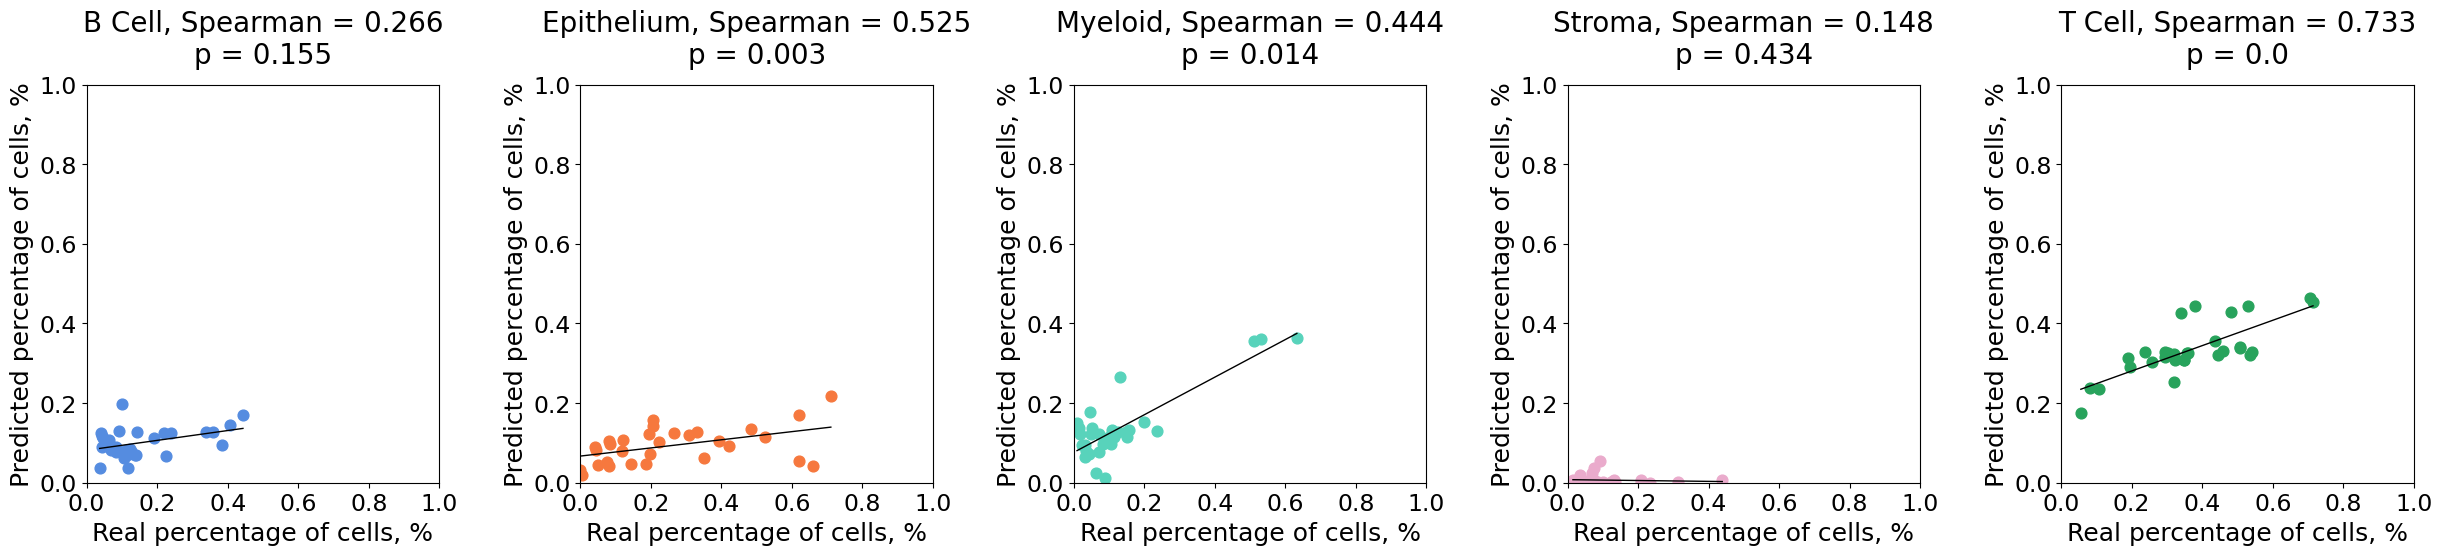

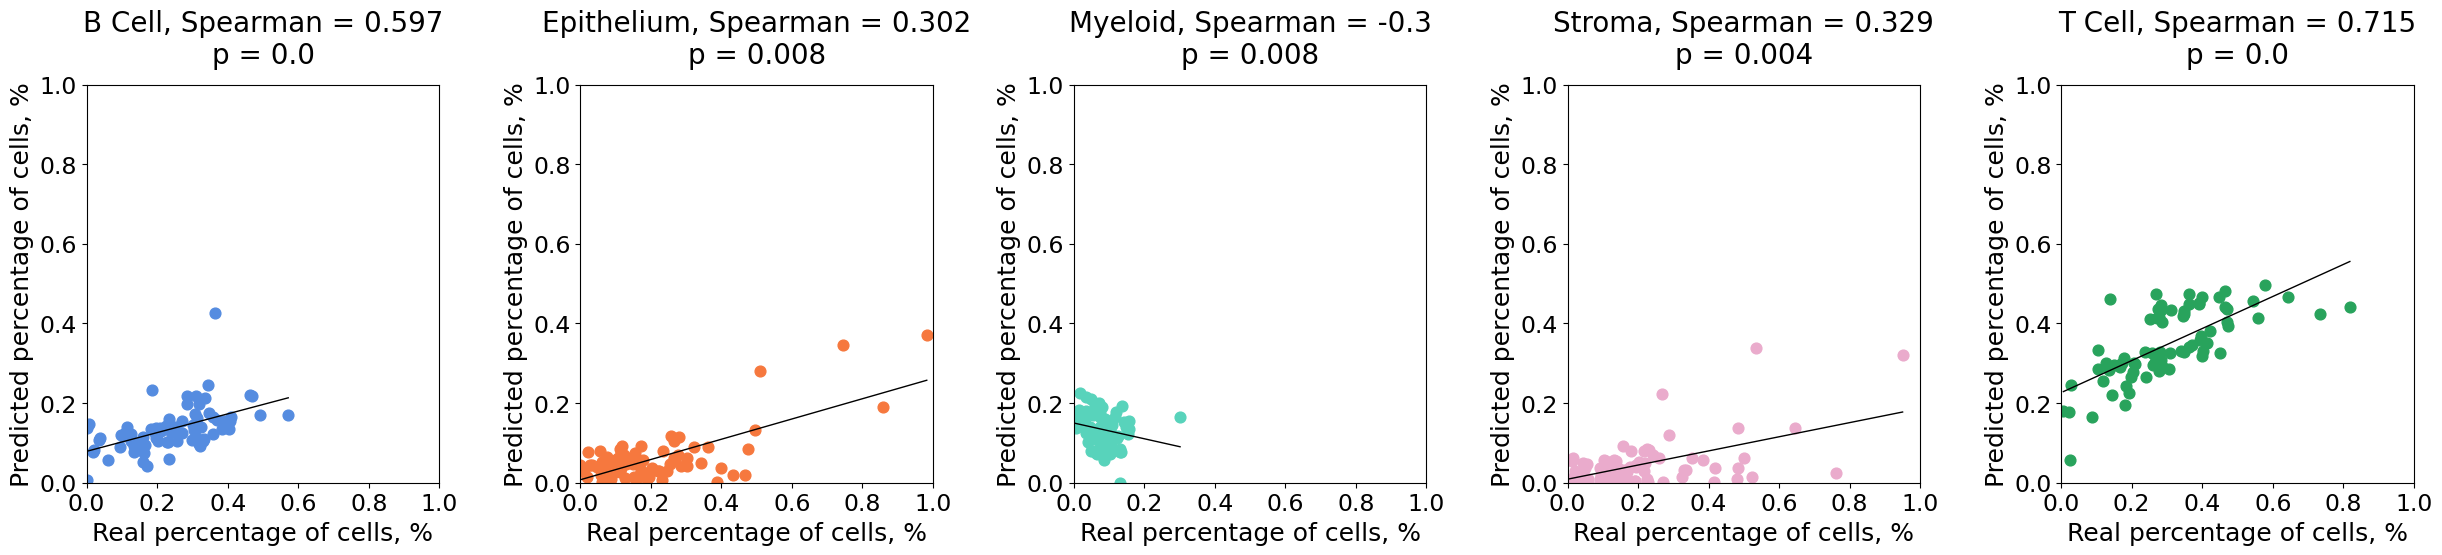

In [32]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)
plot_object.plot_cell(cellanneal_cleveland.T, cleveland_true_general.T, pallete=cells_p)
plot_object.plot_cell(cellanneal_lmu.T, lmu_true_general.T, pallete=cells_p)